In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik


In [3]:
df = pd.read_csv("../ready_data/merged_marwis.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)

In [4]:

# Convert the 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort the DataFrame by timestamp to ensure proper order (if not already sorted)
df = df.sort_values('timestamp')

# Calculate the time difference between each row
df['time_diff'] = df['timestamp'].diff()

# Check for rows where the time difference is greater than the expected interval
# For example, more than 1 second if data is supposed to be at 1-second intervals
gap_threshold = pd.Timedelta(minutes=5)
gaps = df[df['time_diff'] > gap_threshold]
print_gaps = gaps[['timestamp', 'time_diff']]
# Display gaps with their time differences
print("Gaps in Time Series Data:")
print_gaps

Gaps in Time Series Data:


,timestamp,time_diff
50452,2023-12-02 08:09:45+02:00,0 days 11:56:24
111417,2023-12-04 05:32:03+02:00,1 days 04:17:53
169001,2023-12-04 21:35:38+02:00,0 days 01:41:45
169883,2023-12-05 05:37:46+02:00,0 days 07:47:19
226741,2023-12-06 08:07:45+02:00,0 days 12:13:53
...,...,...
2240445,2024-02-27 05:37:21+02:00,0 days 11:00:02
2287196,2024-02-28 05:15:15+02:00,0 days 10:35:14
2334939,2024-02-28 23:38:27+02:00,0 days 05:02:55
2336160,2024-02-29 12:43:57+02:00,0 days 12:46:00


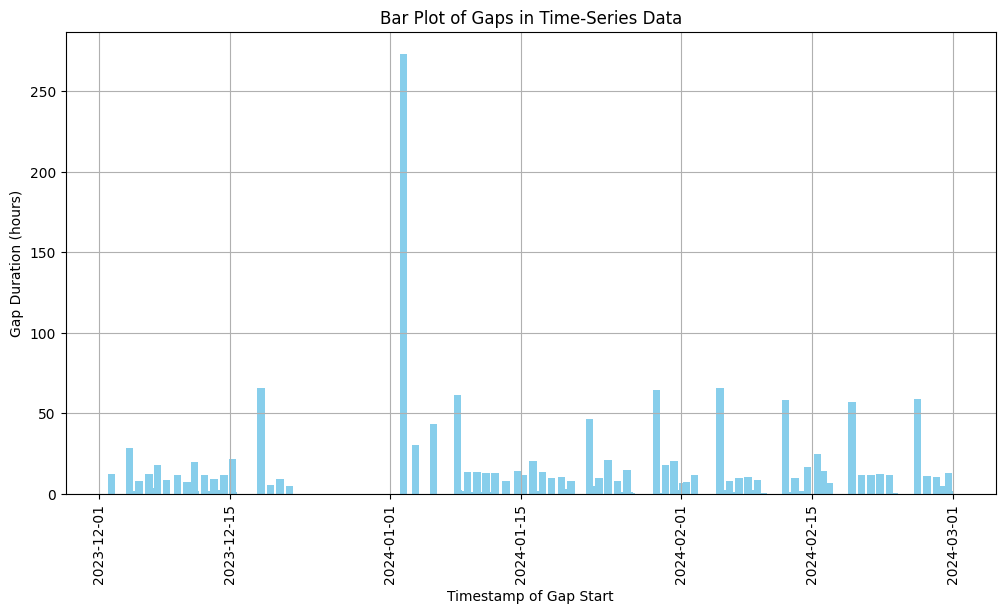

In [5]:
# Create a bar plot for the gaps
plt.figure(figsize=(12, 6))
plt.bar(gaps['timestamp'], gaps['time_diff'].dt.total_seconds()/3600, color='skyblue')

# Label the axes and title
plt.xlabel('Timestamp of Gap Start')
plt.ylabel('Gap Duration (hours)')
plt.title('Bar Plot of Gaps in Time-Series Data')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Big gap during the christmas time, as well as few day gaps during the weekends.
Resampling dataset to get 5 minutes timestep instead of 1 second.

In [6]:
df["ts"] = pd.to_datetime(df.timestamp)

In [7]:
# Resample to 5-minute intervals, applying a specific aggregation function, e.g., mean
df_resampled = df.set_index("ts").resample('10min').mean()  # or .sum(), .first(), etc.
df_resampled.drop("timestamp", axis=1, inplace=True)


In [8]:
df_resampled = df_resampled.dropna()
df_resampled = df_resampled.drop("time_diff", axis=1)

In [9]:
time_range = pd.date_range(start="2023-12-01T04:00:00.000Z", end="2024-02-29T13:15:00.000Z", freq="10min")
missing_dates = time_range[~time_range.isin(df_resampled.index)]
print(missing_dates)

DatetimeIndex(['2023-12-01 18:20:00+00:00', '2023-12-01 18:30:00+00:00',
               '2023-12-01 18:40:00+00:00', '2023-12-01 18:50:00+00:00',
               '2023-12-01 19:00:00+00:00', '2023-12-01 19:10:00+00:00',
               '2023-12-01 19:20:00+00:00', '2023-12-01 19:30:00+00:00',
               '2023-12-01 19:40:00+00:00', '2023-12-01 19:50:00+00:00',
               ...
               '2024-02-29 11:30:00+00:00', '2024-02-29 11:40:00+00:00',
               '2024-02-29 11:50:00+00:00', '2024-02-29 12:00:00+00:00',
               '2024-02-29 12:10:00+00:00', '2024-02-29 12:20:00+00:00',
               '2024-02-29 12:30:00+00:00', '2024-02-29 12:40:00+00:00',
               '2024-02-29 12:50:00+00:00', '2024-02-29 13:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=9137, freq=None)


With 10 minute timestamp, for 3 month, there should be more then 10k rows, but instead we have only 3k. Which means that most of the data is missing.
First, try to parse needed data from starwis weather station

In [10]:
df_resampled.head()

,Amb_T,Friction,Dew_Point_T,RH_at_Road_T,Water_Film_mm,Ice_Percentage,Road_Condition,Water_Film_Surface_mm,Road_Surface_Temperature
ts,,,,,,,,,
2023-12-01 06:00:00+02:00,6.740167,0.672685,0.0,91.247500,0.302345,28.384638,2.585973,0.105781,2.763812
2023-12-01 06:10:00+02:00,1.025961,0.634521,0.0,100.000000,0.225599,53.016434,2.954622,0.081789,-2.535018
2023-12-01 06:20:00+02:00,0.355179,0.631826,0.0,100.000000,0.219426,53.755922,2.812395,0.079770,-2.616895
2023-12-01 06:30:00+02:00,-1.196516,0.550241,0.0,100.000000,0.304002,64.205553,2.983250,0.109549,-3.034178
2023-12-01 06:40:00+02:00,-2.110564,0.528585,0.0,99.668854,0.311157,67.260668,2.823826,0.111411,-3.048302


In [13]:
df_starwis = pd.read_csv("../ready_data/merged_starwis_and_weather.csv")
df_starwis["ts"] = pd.to_datetime(df_starwis.ts)
df_starwis.set_index("ts", inplace=True)


In [14]:
# sample data of same time period as starwis
starwis_sample = df_starwis[(df_starwis.index > "2023-12-01 06:00:00") & (df_starwis.index < "2024-02-29 15:19:10")] 

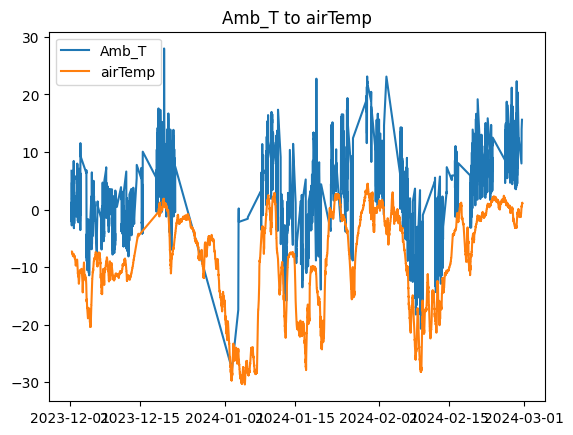

In [15]:
plt.title('Amb_T to airTemp')
plt.plot(df_resampled.index, df_resampled['Amb_T'], label="Amb_T")
plt.plot(starwis_sample.index, starwis_sample['airTemp'], label="airTemp")
plt.legend()


So, Amb_T and airTemp from different datasets actually follows same trend, but there is little difference. May be because of different type of sensor or road in city in simply warmer.

AirTemp has more information, while amb_t has outliers

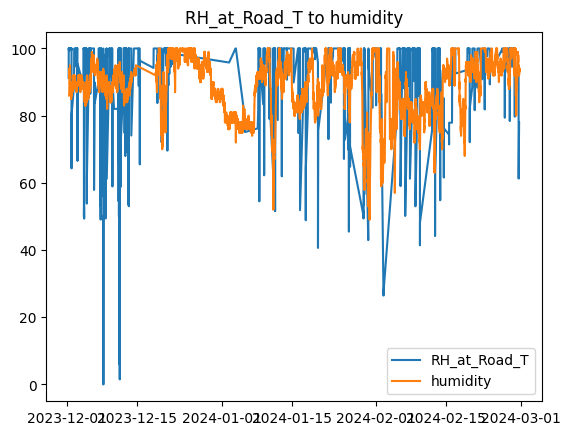

In [16]:
plt.title('RH_at_Road_T to humidity')
plt.plot(df_resampled.index, df_resampled['RH_at_Road_T'], label="RH_at_Road_T")
plt.plot(starwis_sample.index, starwis_sample['humidity'], label="humidity")
plt.legend()


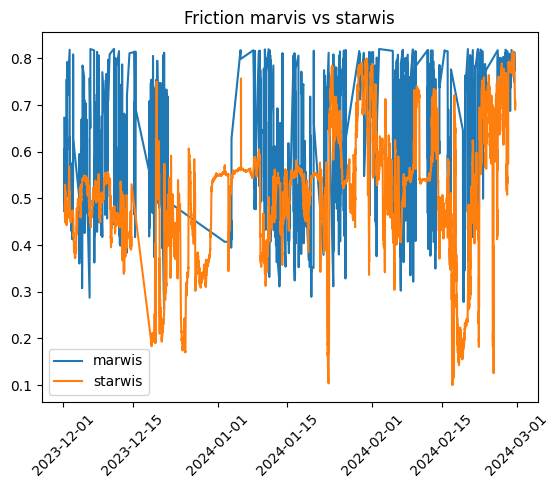

In [17]:
plt.title('Friction marvis vs starwis')
plt.plot(df_resampled.index, df_resampled['Friction'], label="marwis")
plt.plot(starwis_sample.index, starwis_sample['Friction'], label="starwis")
plt.xticks(rotation=45)
plt.legend()


In general, starwis and marwis in the same time period follow same trend. However, marwis has few problems:

1. Outliers due to sensor nature and mobility
2. Gaps in data whenever bus is not on route: every night, every weekend, every holiday
3. Mobility of the bus

So it seems that it is easier to use combined starwis and weather station dataset.
Let's see what months would have relevance for us.

In [18]:
# split df to years
df_2021 = df_starwis[df_starwis.index < "2022-01-01 00:00:00"]
df_2022 = df_starwis[(df_starwis.index >= "2022-01-01 00:00:00") & (df_starwis.index < "2023-01-01 00:00:00")]
df_2023 = df_starwis[(df_starwis.index >= "2023-01-01 00:00:00") & (df_starwis.index < "2024-01-01 00:00:00")]
df_2024 = df_starwis[(df_starwis.index >= "2024-01-01 00:00:00") & (df_starwis.index < "2025-01-01 00:00:00")]

To filter the data we need, let's see what month

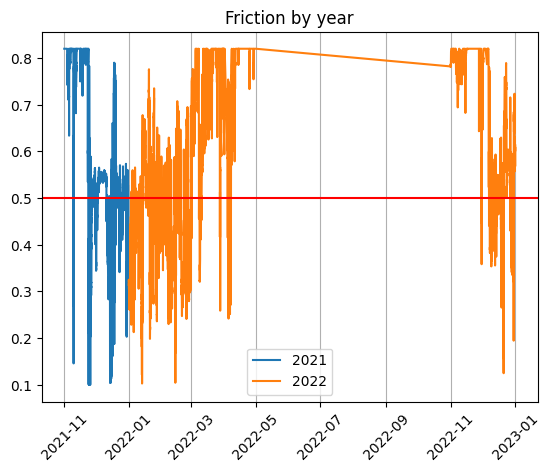

In [19]:
plt.title('Friction by year')
plt.plot(df_2021.index, df_2021.Friction, label="2021")
plt.plot(df_2022.index, df_2022.Friction, label="2022")
plt.axhline(y = 0.5, color = 'r', linestyle = '-') 
plt.xticks(rotation=45)
plt.grid(axis="x")
plt.legend()


<h1>2021-2022 winter season</h1>
Friction gets below 0.5 first times at 2021-11 and ends after 2022-04

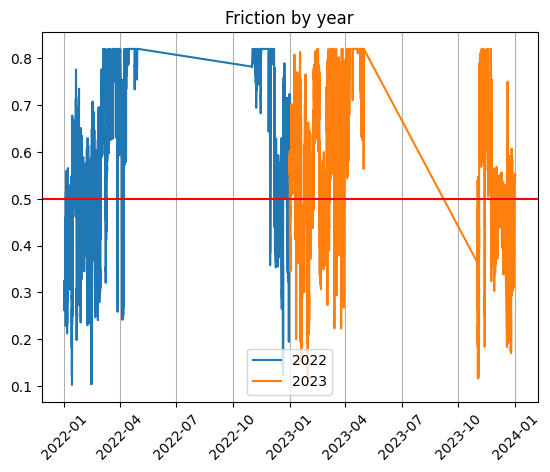

In [20]:
plt.title('Friction by year')
plt.plot(df_2022.index, df_2022.Friction, label="2022")
plt.plot(df_2023.index, df_2023.Friction, label="2023")
plt.axhline(y = 0.5, color = 'r', linestyle = '-') 
plt.xticks(rotation=45)
plt.grid(axis="x")
plt.legend()


Same dates, 2022-11 to 2023-04

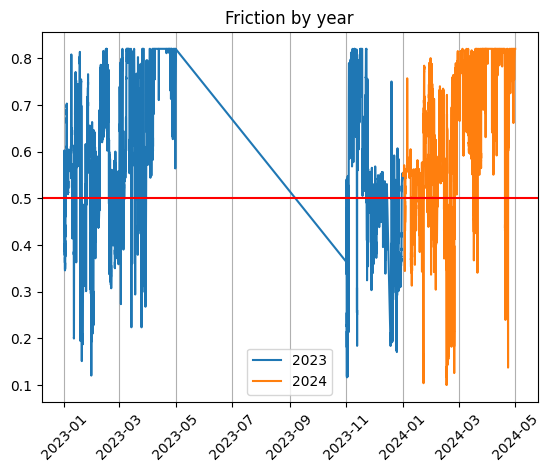

In [21]:
plt.title('Friction by year')
plt.plot(df_2023.index, df_2023.Friction, label="2023")
plt.plot(df_2024.index, df_2024.Friction, label="2024")
plt.axhline(y = 0.5, color = 'r', linestyle = '-') 
plt.xticks(rotation=45)
plt.grid(axis="x")
plt.legend()


Every year has almost same situation. So let's keep only the data we need (November to March)

<h1>Zik analisys copy</h1>

In [22]:
# Read csv file into dataframe
df = pd.read_csv("../ready_data/merged_starwis_and_weather.csv")

df.head()

,ts,airTemp,humidity,dewpoint,precipitation,Friction,Road_Surface_Temperature,Water_Film_Surface_mm
0,2021-11-01 00:05:00,8.8,94.0,7.9,0,0.82,5.082435,0.0
1,2021-11-01 00:15:00,9.1,91.0,7.7,0,0.82,5.035252,0.0
2,2021-11-01 00:25:00,9.1,90.0,7.5,0,0.82,4.951386,0.0
3,2021-11-01 00:35:00,9.2,88.0,7.3,0,0.82,5.077870,0.0
4,2021-11-01 00:45:00,9.2,86.0,7.0,0,0.82,4.919721,0.0


In [23]:
df.describe()

,airTemp,humidity,dewpoint,precipitation,Friction,Road_Surface_Temperature,Water_Film_Surface_mm
count,73551.000000,73551.000000,73551.000000,73551.000000,73551.000000,73551.000000,73551.000000
mean,-2.935748,85.606341,-5.332746,0.963141,0.622272,-2.372860,0.113000
std,6.888750,15.246334,6.695510,1.658930,0.175966,6.383595,0.219764
min,-30.400000,18.000000,-33.500000,0.000000,0.100005,-24.663725,0.000000
25%,-6.100000,81.000000,-8.900000,0.000000,0.492877,-5.351678,0.010472
50%,-1.900000,90.000000,-4.300000,0.000000,0.626066,-1.642551,0.063360
75%,1.200000,96.000000,-0.500000,1.000000,0.813875,0.815219,0.121397
max,17.400000,100.000000,11.100000,6.000000,0.820000,23.930937,6.000000


In [24]:
df.columns

Index(['ts', 'airTemp', 'humidity', 'dewpoint', 'precipitation', 'Friction',
       'Road_Surface_Temperature', 'Water_Film_Surface_mm'],
      dtype='object')

In [25]:
# No missing values for the merged datasets 
df.isnull().sum()

ts                          0
airTemp                     0
humidity                    0
dewpoint                    0
precipitation               0
Friction                    0
Road_Surface_Temperature    0
Water_Film_Surface_mm       0
dtype: int64

In [26]:
# Check the correleation matrix
correlation_matrix = df.drop("ts",axis=1).corr()
target_corr = correlation_matrix["Friction"].sort_values(ascending=False)
print(target_corr)

Friction                    1.000000
Road_Surface_Temperature    0.477911
airTemp                     0.435404
dewpoint                    0.286418
precipitation              -0.255894
Water_Film_Surface_mm      -0.329332
humidity                   -0.343617
Name: Friction, dtype: float64


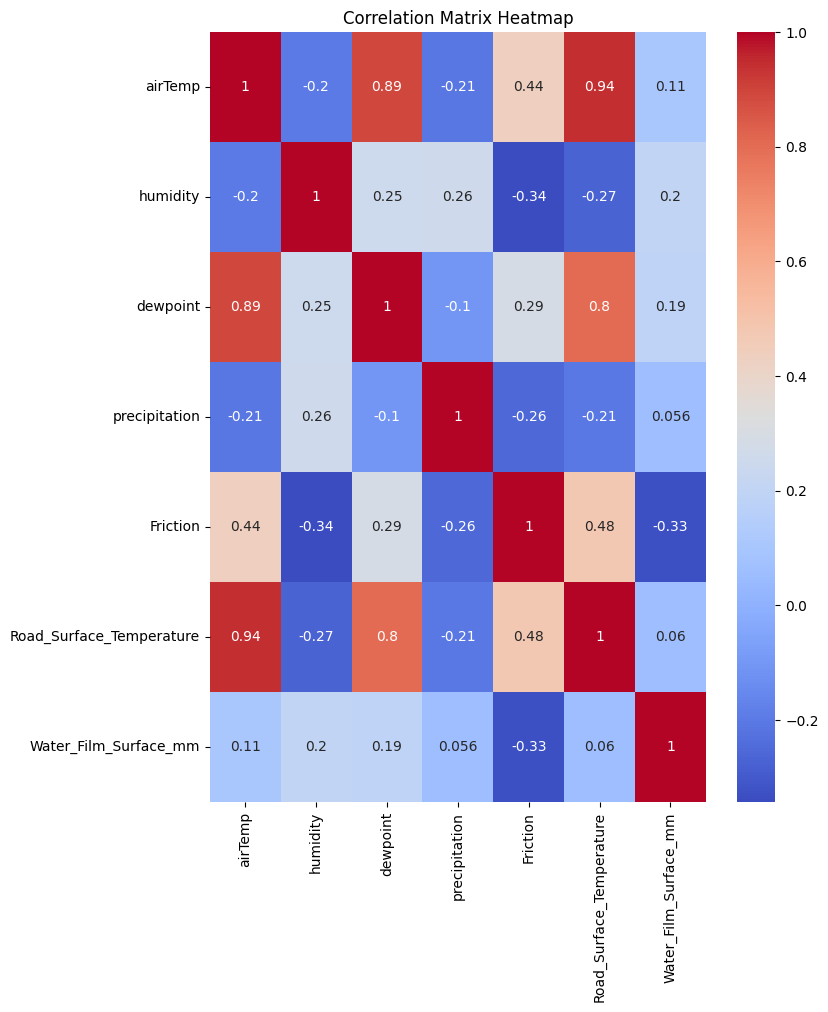

In [28]:
# Visualize the correlation
plt.figure(figsize=(8, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

<h2>Overlaps and Redundancy</h2>
According to this correlation above I can't consider any of the variables redundant because they are all unique to each other.

But the correlation between Dewpoint and airTemp is 91%

The correlation between Road_Surface_Temperature and AirTemp is 97% this significant amount of correlation can actually signify redundancy

There's an overlap between Air temp and Road_Surface_Temperature

<h2>Noises</h2>

This datasets do not have a lot of noise in it most of the value are close to the average or the values make up the average.

The only column I could consider that has noise is dew point at the far left of its distribution

The precipitation column has 82% zero values I think it's best to drop the column

The Water_Film_Surface_mm has over 57% of zero values. I would take that as missing values and I'd try to fill it.

![Screenshot 2024-11-11 at 9.43.54 PM.png](<attachment:Screenshot 2024-11-11 at 9.43.54 PM.png>)

interval columns not set, guessing: ['airTemp', 'humidity', 'dewpoint', 'precipitation', 'Friction', 'Road_Surface_Temperature', 'Water_Film_Surface_mm']


/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable ts is large: 73551. Are you sure this is not an interval variable? Analysis for pairs of variables including ts can be slow.
  warnings.warn(


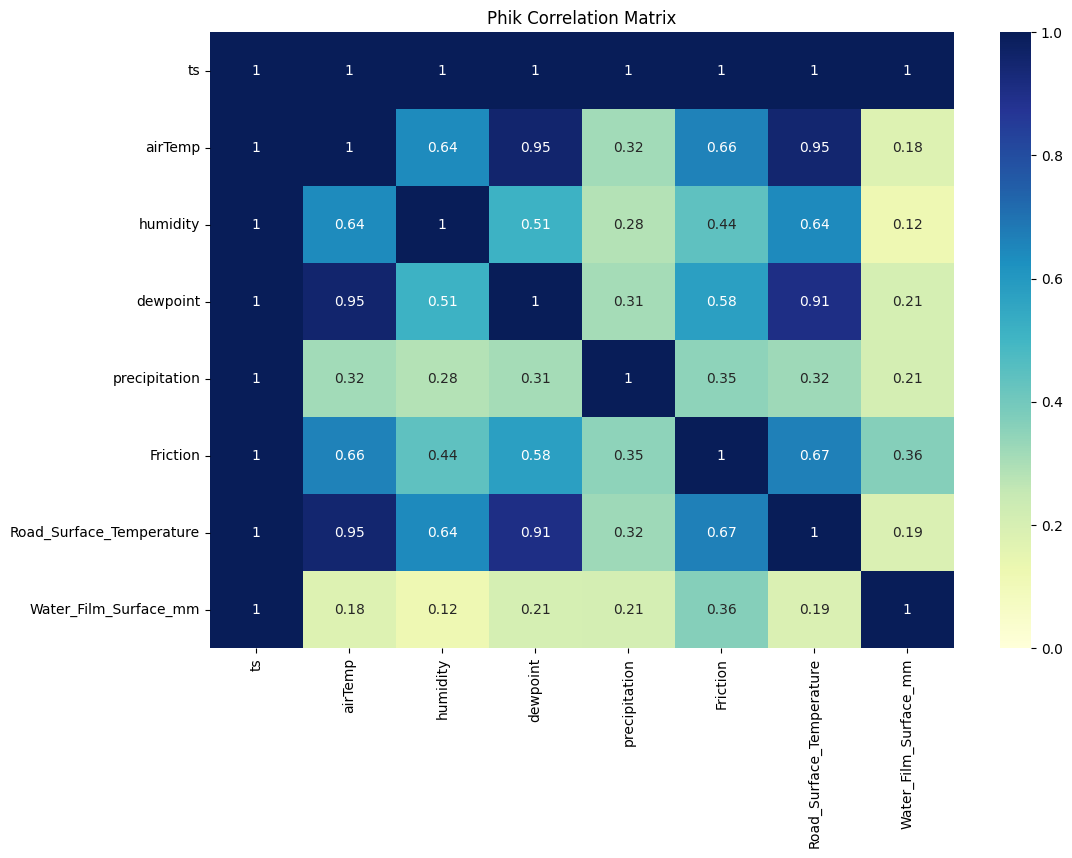

In [31]:
# compute phik-matrix values
phik_matrix = df.phik_matrix()
# Set up the plot size
plt.figure(figsize=(12, 8))

# Use seaborn's heatmap to plot the matrix
sns.heatmap(phik_matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1, cbar=True)
plt.title("Phik Correlation Matrix")
plt.show()